# **6610210301 ภานุพงศ์ สนไชย**

# Lab04 - Detectors

In this exercise, you will learn how to implement several detectors that are the foundation for keypoint (feature point) extraction. We will:

1. Detect edges using a derivative filter.
2. Detect edges using the Sobel operator.
3. Detect edges using a Gaussian derivative.
4. Calculate corner scores using the sum of squared differences (SSD).
5. Implement the Harris corner detector.


## 4.0 Setup and Utility Functions

First, make sure you have installed the required libraries and check what is your *present working directory*:

In [ ]:
!pip install numpy pillow
!echo "Your current directory is: $(pwd)"

Your current directory is: /content


You are provided with some utility functions for reading, writing, and rendering images.

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
import colorsys

%matplotlib inline


"""
Utility functions to read, to display, and to save an image
"""
def read_img(path, greyscale=True):
    img = Image.open(path)
    if greyscale:
        img = img.convert('L')
    else:
        img = img.convert('RGB')
    return np.array(img).astype(float)


def show_img(img_array, cmap=None, title=""):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title(title)
    if cmap is None:
        img_array = img_array - img_array.min()
        img_array = img_array / img_array.max()
        img_array = (img_array * 255).astype(np.uint8)
        plt.imshow(img_array, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(img_array, cmap=cmap, vmin=0, vmax=255)
    plt.show()


def save_img(img, path):
    img = img - img.min()
    img = img / img.max()
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(path)
    print(path, "is saved!")


"""
Extract the peak x,y locations
Input
  scale_space: Scale space of size HxWxS
  k: neighborhood in x and y
Output
  list of (x,y) tuples;
"""
def find_maxima(img, k_xy=5):

    H, W = img.shape
    maxima = []
    for i in range(H):
        for j in range(W):
            # extracts a local neighborhood of max size
            # (2k_xy+1, 2k_xy+1)
            neighbors = img[max(0, i - k_xy):min(i + k_xy + 1, H),
                            max(0, j - k_xy):min(j + k_xy + 1, W)]
            mid_pixel = img[i, j]
            num_neighbors = np.prod(neighbors.shape) - 1 #ถ้า mid > neighbors ทุกตัว ลบ 1 เอาตัวเองออก prod นำจำนวนคูน11*11 if neighbors.shape = 11
            # if mid_pixel > all the neighbors; append maxima
            if np.sum(mid_pixel > neighbors) == num_neighbors:
                maxima.append((i, j))
    return maxima


"""
Visualizes the maxima on a given image
Input
  image: image of size HxW
  maxima: list of (x,y) tuples; x<W, y<H
  file_path: path to save image. if None, display to screen
Output
  None
"""
def visualize_maxima(image, maxima, radius=1, file_path=None):
    H, W = image.shape
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for maximum in maxima:
        y, x = maximum
        assert x < W and y < H and x >= 0 and y >= 0
        circ = plt.Circle((x, y), radius, color='r', fill=False)
        ax.add_patch(circ)

    if file_path:
        plt.savefig(file_path)
    else:
        plt.show()

## 4.1 Simple Edge Detection (Derivative Filters)

Edges can be detected by computing intensity changes in the horizontal and vertical directions.
We use simple derivative filters `[-1, 0, 1]` (for x) and its transpose (for y).
The gradient magnitude combines both directions to highlight edge strength.


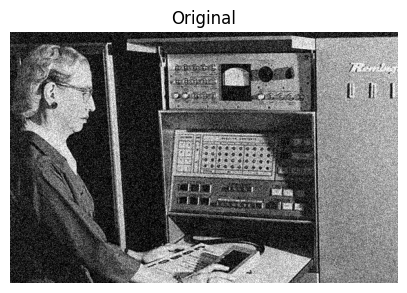

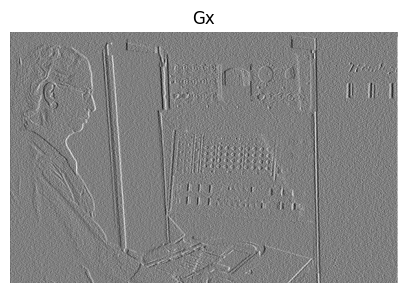

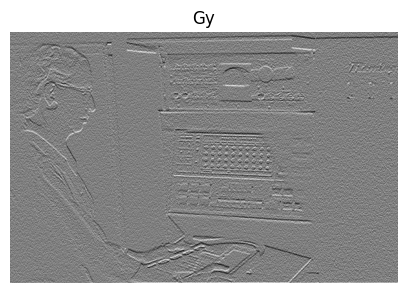

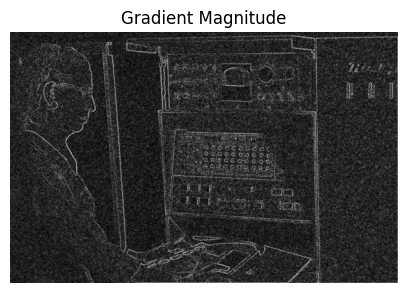

In [13]:
def simple_edge_detection(image):
    # Derivative filters
    kx = np.array([[-1,0,1]]) # Reshape kx to be a 2D array
    ky = np.array([[-1],[0],[1]]) # Reshape ky to be a 2D array, transpose of the original ky

    Gx =convolve(image,kx,mode="constant",cval=0.0)
    Gy = convolve(image,ky,mode="constant",cval=0.0)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, gradient_magnitude

# Test simple_edge_detection()
img = read_img("grace_hopper_gauss_noise.png")
show_img(img, title="Original")

Gx, Gy, mag = simple_edge_detection(img)
show_img(Gx, title="Gx")
show_img(Gy, title="Gy")
show_img(mag, title="Gradient Magnitude")

## 4.2 Sobel Filter

The Sobel filter improves edge detection by combining derivative filters with smoothing. It reduces noise sensitivity while still highlighting horizontal and vertical edges.

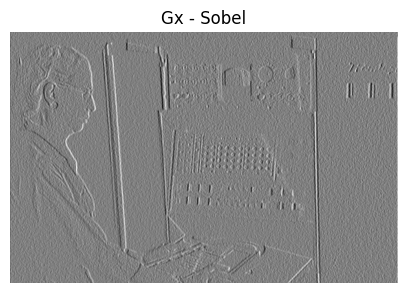

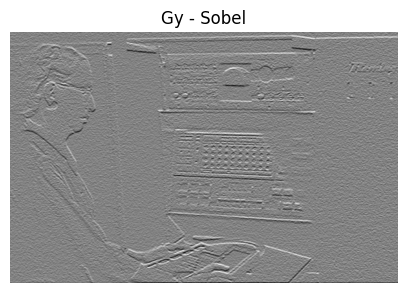

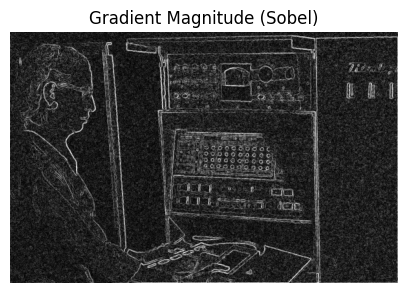

In [14]:
def sobel_filter(image):
    Sx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
    Sy = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])
    Gx =convolve(image,Sx,mode="constant",cval=0.0)
    Gy = convolve(image,Sy,mode="constant",cval=0.0)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, gradient_magnitude

# Test sobel_filter()
Gx, Gy, mag = sobel_filter(img)
show_img(Gx, title="Gx - Sobel")
show_img(Gy, title="Gy - Sobel")
show_img(mag, title="Gradient Magnitude (Sobel)")

## 4.3 Gaussian Derivative Edge Detection

Sometimes images are noisy. Before computing derivatives, we smooth them with a Gaussian filter. This yields more stable edges. The Gaussian derivative filter approximates this by combining smoothing and differentiation.


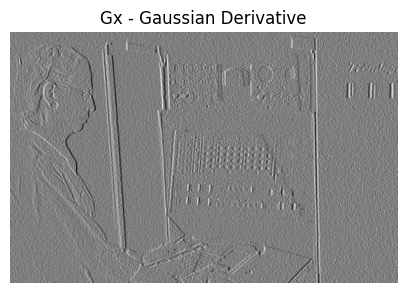

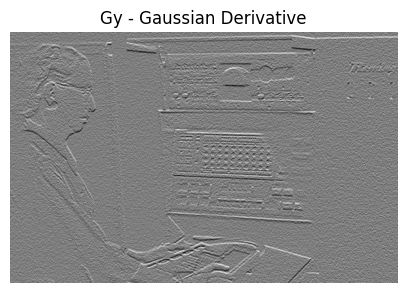

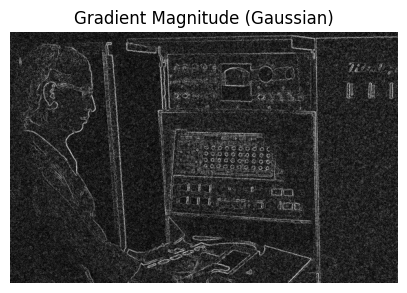

In [16]:
def gaussian_derivative_edge(image, window_size=5, sigma=0.3):
    # Gaussian smoothed derivatives
    Gx = gaussian_filter(image, sigma=sigma, order=(0, 1)) # Derivative in x direction
    Gy = gaussian_filter(image, sigma=sigma, order=(1, 0)) # Derivative in y direction

    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, gradient_magnitude

# Test gaussian_derivative_edge()
Gx, Gy, mag = gaussian_derivative_edge(img, window_size=3, sigma=0.5)
show_img(Gx, title="Gx - Gaussian Derivative")
show_img(Gy, title="Gy - Gaussian Derivative")
show_img(mag, title="Gradient Magnitude (Gaussian)")

## 4.4 Corner Score (SSD-based)

A corner is a region where intensity changes in multiple directions.
The **corner score** is computed using the **sum of squared differences (SSD)** between a window around each pixel and a shifted version of that window.
Large SSD values suggest strong corners.

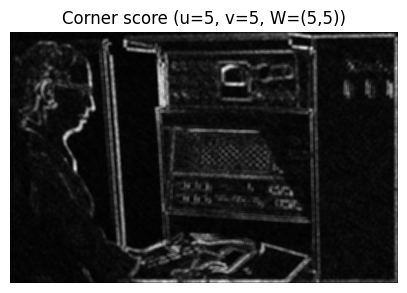

In [45]:
"""
Given an input image, x_offset, y_offset, and window_size,
return the function E(u,v) for window size W
corner detector score for that pixel.
Use zero-padding to handle window values outside of the image.

Input
  image: H x W
  u: a scalar for x offset
  v: a scalar for y offset
  window_size: a tuple for window size
Output
  score: a image of size H x W
"""
def corner_score(image, u=5, v=5, window_size=(5, 5)):
    shifted=np.roll(image,shift=(-u,-v),axis=(1,0)) #got new image name shift
    sd=(shifted-image)**2
    ssd=convolve(sd,np.ones(window_size),mode="constant",cval=0.0)

    return ssd

# Test corner_score()
score = corner_score(img, u=5, v=5)
show_img(score, title="Corner score (u=5, v=5, W=(5,5))")

### Caculate corner scores for every pixels in a scan region

In [ ]:
# Calculate corner score for a whole region
scores = []
scan_size = 10
for v in range(-scan_size, scan_size+1):
    for u in range(-scan_size, scan_size+1):
        score = corner_score(img, u=u, v=v)
        scores.append(score)
# ที่ stacked_scores กลายเป็น array 3 มิติ ก็เพราะว่าฟังก์ชัน np.stack ทำหน้าที่นำ array 2 มิติหลายๆ อันมา "ซ้อนกันเป็นตั้ง" ซึ่งการซ้อนกันนี้จะสร้าง "มิติใหม่" ขึ้นมาครับ

# คำอธิบาย
# scores คือ "ลิสต์ของภาพ 2 มิติ"

# ในแต่ละรอบของ for loop ฟังก์ชัน corner_score จะคำนวณและคืนค่า score ออกมา

# score แต่ละอันคือ ภาพ 2 มิติ (array ขนาด สูง x กว้าง) ที่แต่ละพิกเซลเก็บ "คะแนนความเป็นมุม" สำหรับการเลื่อน (u, v) ในรอบนั้นๆ

# เมื่อลูปทำงานจนครบ scores จะกลายเป็นลิสต์ที่ข้างในเต็มไปด้วยภาพคะแนน 2 มิติเหล่านี้

# np.stack คือ "การซ้อนภาพเป็นชั้นๆ" 📚

# np.stack(scores, axis=0) จะนำภาพ 2 มิติทุกภาพที่อยู่ในลิสต์ scores มาวางซ้อนกันเหมือนการซ้อนหน้ากระดาษในหนังสือ

# การซ้อนนี้ทำให้เกิด มิติที่ 3 ขึ้นมา ซึ่งก็คือมิติของ "หน้า" หรือ "ชั้น" ที่ใช้แยกแยะว่าคะแนนนี้มาจากการเลื่อน (u, v) แบบไหน

# ผลลัพธ์ที่ได้ (stacked_scores) จึงมี 3 มิติ ดังนี้:

# มิติที่ 0 (axis=0): คือ ดัชนีของชั้น ที่บอกว่าคะแนนนี้มาจากการเลื่อน (u, v) คู่ไหน

# มิติที่ 1 (axis=1): คือ แกนของแถว (ความสูง) ของภาพ

# มิติที่ 2 (axis=2): คือ แกนของคอลัมน์ (ความกว้าง) ของภาพ

# ดังนั้น array 3 มิตินี้จึงเป็นวิธีที่มีประสิทธิภาพในการเก็บผลลัพธ์ของ "คะแนนความเป็นมุม" จากการทดลองเลื่อนในทุกๆ ทิศทาง (u, v) ไว้ในตัวแปรเดียวครับ
# Stack scores into a 3D array fukyou
stacked_scores = np.stack(scores, axis=0)
size = int(np.sqrt(stacked_scores.shape[0]))

Show the result at a specific position.

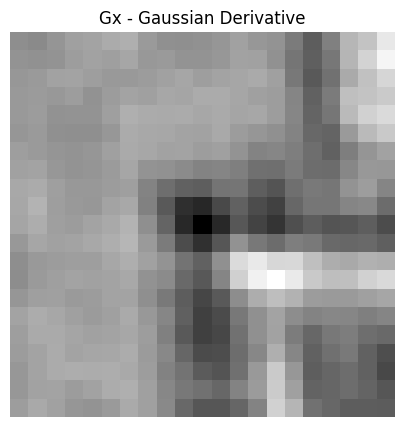

In [47]:
# Show result in the scan region
pos_x = 230
pos_y = 123
cscore = stacked_scores[:, pos_y, pos_x].reshape(size, size)
show_img(cscore, title="Gx - Gaussian Derivative")

## 4.5 Harris Corner Detector

The **Harris corner detector** improves on SSD by using image gradients and a **structure tensor**.
It analyzes intensity changes in all directions within a local window and produces a score `R`.

* Large positive `R` → corner
* Negative `R` → edge
* Near zero `R` → flat region


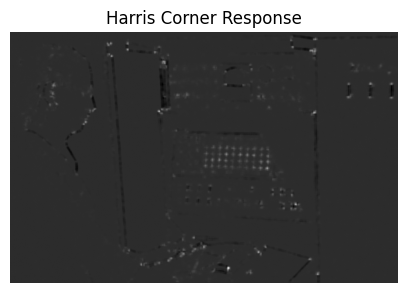

In [50]:
def harris_detector(image, window_size=(5, 5), alpha=0.05, sigma=1.0):
    # compute the derivatives
    Ix = gaussian_filter(image,sigma,order=(0,1))
    Iy = gaussian_filter(image,sigma,order=(1,0))

    Ixx = Ix*Ix
    Iyy = Iy*Iy
    Ixy = Ix*Iy

    mxx=convolve(Ixx,np.ones(window_size),mode="constant",cval=0.0)
    myy=convolve(Iyy,np.ones(window_size),mode="constant",cval=0.0)
    mxy=convolve(Ixy,np.ones(window_size),mode="constant",cval=0.0)

    detM=mxx*myy-mxy**2
    traceM=mxx+myy
    R=detM-alpha*(traceM**2)
    # For each image location, construct the structure tensor and calculate
    # the Harris response
    response = R
    return response

# Test harris_detector()
R = harris_detector(img, window_size=(5,5), alpha=0.05)
R = R - R.min()
R = R / R.max()
show_img(R, title="Harris Corner Response")
#print(f"R: min={R.min()}, max={R.max()}")

### Threshold R

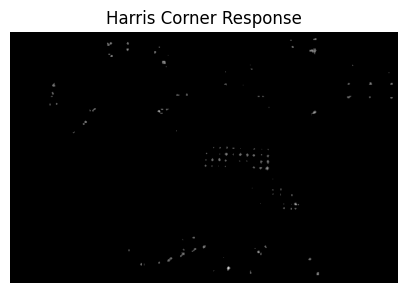

In [51]:
1# Define the threshold
threshold = 0.3

thres_R = np.where(R > threshold, R, 0)
show_img(thres_R, title="Harris Corner Response")

### Find local maxima

Number of maxima: 102


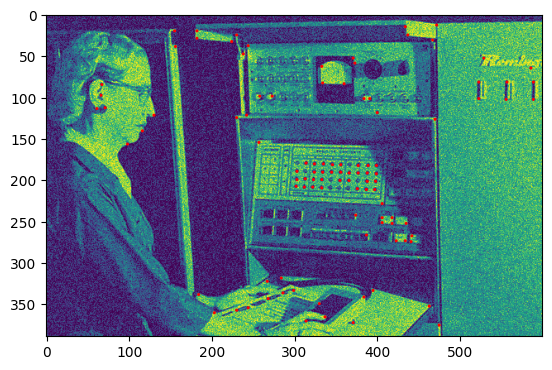

In [52]:
# Find local maxima (using non-maxima suppression)
maxima = find_maxima(thres_R, k_xy=5)
print(f"Number of maxima: {len(maxima)}")
visualize_maxima(img, maxima, radius=1)